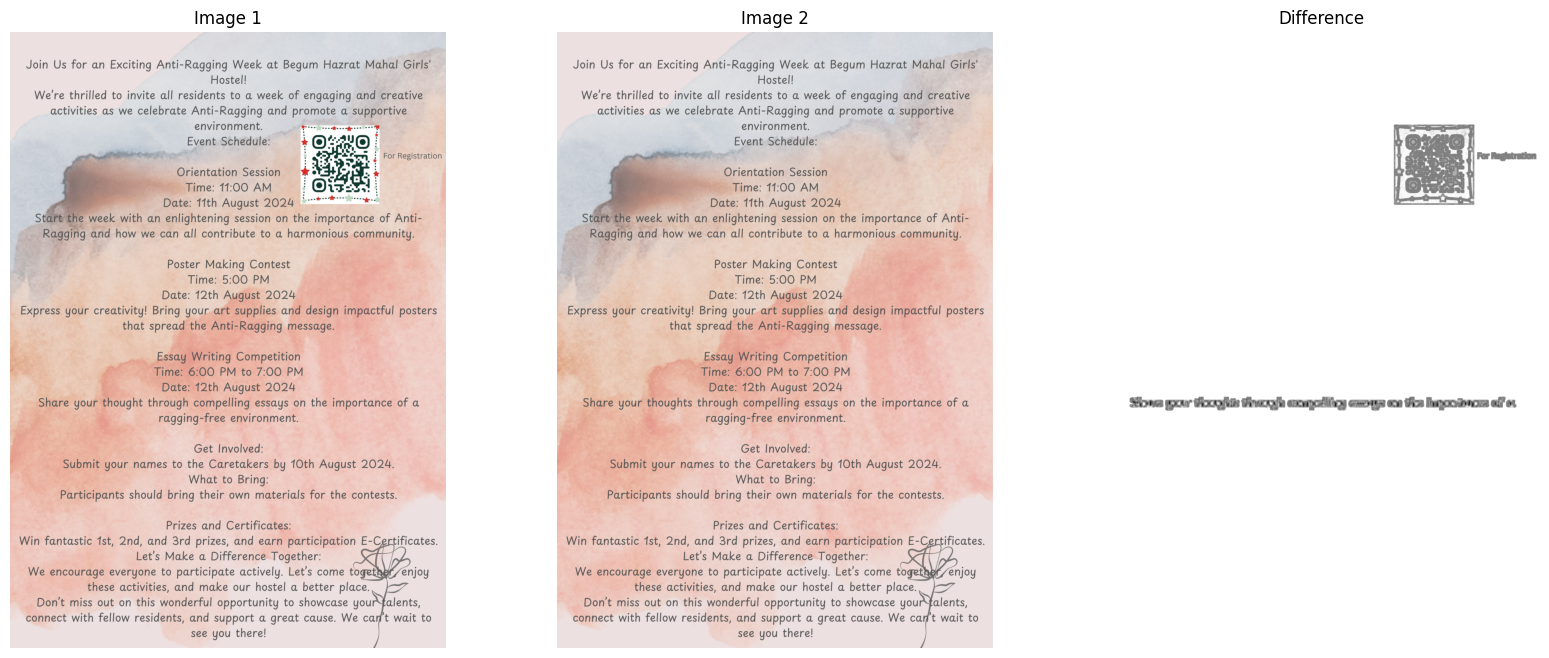

In [65]:
import os
import tempfile
import shutil
import io
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

def read_file_from_local(path):
    try:
        with open(path, 'rb') as f:
            file_contents = f.read()
        return file_contents
    except IOError as e:
        print(f"Error reading file: {e}")
        return ""

def compute_ssim(img1, img2):
    """
    Compute the Structural Similarity Index (SSIM) between two images.

    Args:
        img1 (numpy array): First image
        img2 (numpy array): Second image

    Returns:
        float: SSIM score between 0 and 1
        numpy array: Difference image
    """
    ssim_score, diff = ssim(img1, img2, full=True)
    return ssim_score, diff

def compare_images_ssim(image1_path, image2_path):
    """
    Compare two images using SSIM and return a boolean indicating whether they are identical.

    Args:
        image1_path (str): Path to the first image
        image2_path (str): Path to the second image

    Returns:
        bool: True if the images are identical, False otherwise
        numpy array: Difference image
    """
    try:
        img1_bytes = read_file_from_local(image1_path)
        img2_bytes = read_file_from_local(image2_path)

        if not img1_bytes or not img2_bytes:
            print("Error: Unable to read one or both images")
            return False, None

        img1_stream = io.BytesIO(img1_bytes)
        img2_stream = io.BytesIO(img2_bytes)

        img1 = Image.open(img1_stream)
        img2 = Image.open(img2_stream)

        # Resize images to have the same dimensions
        img1 = img1.resize(img2.size)

        img1 = np.array(img1.convert('L'))
        img2 = np.array(img2.convert('L'))

        ssim_score, diff = compute_ssim(img1, img2)

        return ssim_score >= 0.99, diff  # adjust the threshold as needed
    except Exception as e:
        print(f"Error comparing images: {e}")
        return False, None

def show_images(image1_path, image2_path):
    identical, diff = compare_images_ssim(image1_path, image2_path)
    
    if diff is not None:
        fig, axes = plt.subplots(1, 3, figsize=(20, 8))
        ax = axes.ravel()

        img1 = Image.open(image1_path)
        img2 = Image.open(image2_path)

        ax[0].imshow(img1, cmap=plt.cm.gray)
        ax[0].set_title('Image 1')

        ax[1].imshow(img2, cmap=plt.cm.gray)
        ax[1].set_title('Image 2')

        ax[2].imshow(diff, cmap=plt.cm.gray)
        ax[2].set_title('Difference')

        for a in ax:
            a.axis('off')

        plt.show()
    else:
        print("Could not compute the difference image.")

# Example usage for comparing images and showing differences
image1_path = "resource/Make a difference (1).png"
image2_path = "resource/sdadsda.png"

show_images(image1_path, image2_path)

Test Code for proper ouput

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


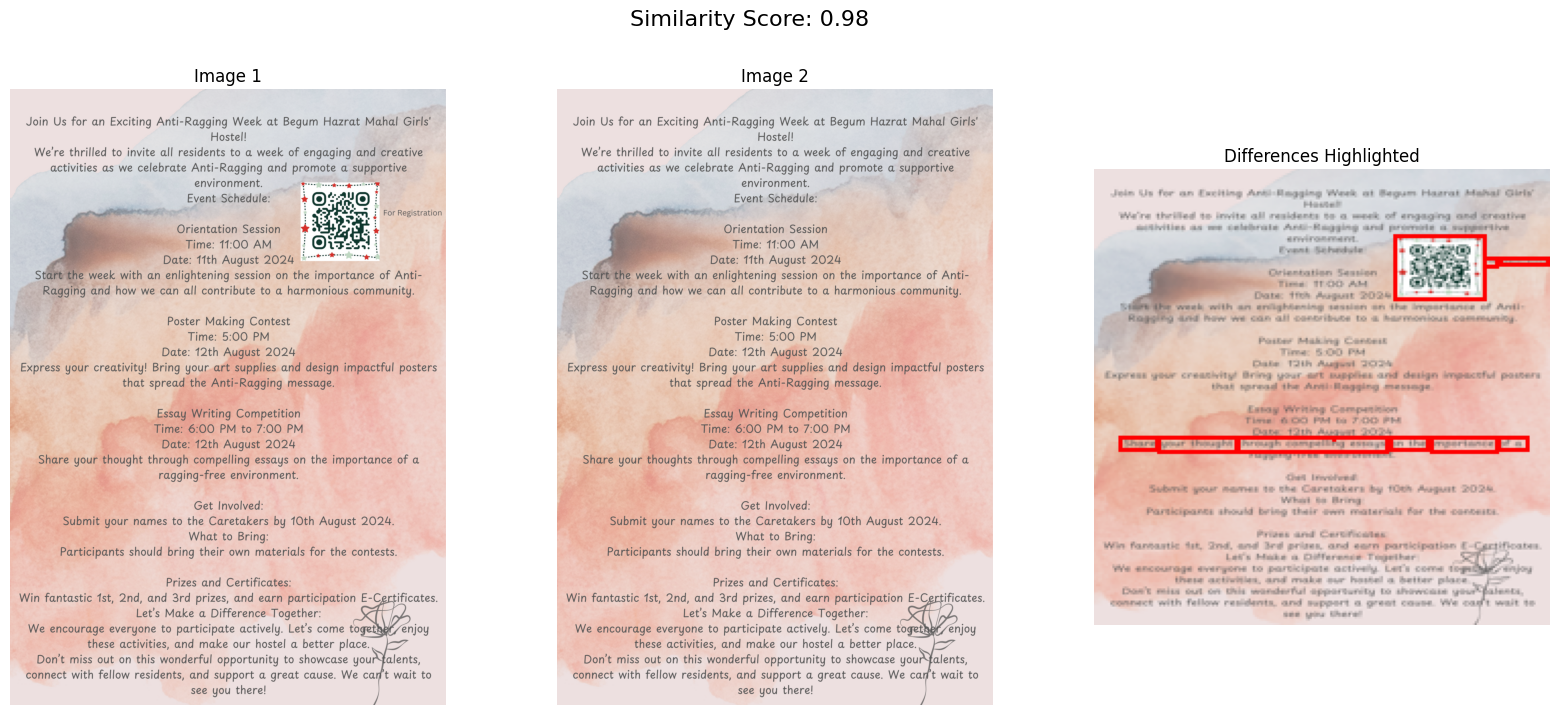

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageDraw
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
import cv2
import os
import shutil
from datetime import datetime

# Load the VGG16 model pre-trained on ImageNet
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

def read_and_preprocess_image(img_path):
    """
    Read and preprocess an image for VGG16 model.

    Args:
        img_path (str): Path to the image file

    Returns:
        numpy array: Preprocessed image
    """
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def extract_features(img_path):
    """
    Extract features from an image using VGG16 model.

    Args:
        img_path (str): Path to the image file

    Returns:
        numpy array: Feature vector
    """
    img_array = read_and_preprocess_image(img_path)
    features = model.predict(img_array)
    return features

def compare_images_dense_vectors(image1_path, image2_path):
    """
    Compare two images using Dense Vector Representations and return the similarity score.

    Args:
        image1_path (str): Path to the first image
        image2_path (str): Path to the second image

    Returns:
        float: Similarity score between 0 and 1
    """
    features1 = extract_features(image1_path)
    features2 = extract_features(image2_path)

    similarity = cosine_similarity(features1, features2)
    return similarity[0][0]

def highlight_differences(image1_path, image2_path, output_dir):
    img1 = Image.open(image1_path).convert('RGB')
    img2 = Image.open(image2_path).convert('RGB')

    # Resize images to the same size
    img1 = img1.resize((224, 224))
    img2 = img2.resize((224, 224))

    # Convert images to numpy arrays
    img1_array = np.array(img1)
    img2_array = np.array(img2)

    # Compute absolute difference
    diff = np.abs(img1_array - img2_array)

    # Convert the difference to grayscale
    diff_gray = np.mean(diff, axis=2).astype(np.uint8)

    # Apply a binary threshold to get the regions of difference
    _, thresh = cv2.threshold(diff_gray, 30, 255, cv2.THRESH_BINARY)

    # Find contours of the differing regions
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes around the differing regions
    draw = ImageDraw.Draw(img1)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        draw.rectangle([x, y, x+w, y+h], outline='red', width=2)

    # Get current date and epoch time
    current_time = datetime.now()
    date_str = current_time.strftime("%Y%m%d")
    epoch_time = int(current_time.timestamp())

    # Save the image with highlighted differences
    output_filename = f'highlighted_differences_{date_str}_{epoch_time}.png'
    output_path = os.path.join(output_dir, output_filename)
    img1.save(output_path)

    return img1

def show_images(image1_path, image2_path, output_dir):
    similarity = compare_images_dense_vectors(image1_path, image2_path)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    ax = axes.ravel()

    img1 = Image.open(image1_path)
    img2 = Image.open(image2_path)
    img_diff = highlight_differences(image1_path, image2_path, output_dir)

    ax[0].imshow(img1)
    ax[0].set_title('Image 1')

    ax[1].imshow(img2)
    ax[1].set_title('Image 2')

    ax[2].imshow(img_diff)
    ax[2].set_title('Differences Highlighted')

    for a in ax:
        a.axis('off')

    plt.suptitle(f'Similarity Score: {similarity:.2f}', fontsize=16)
    plt.show()

# Example usage for comparing images and showing differences
image1_path = r"C:\Users\acer\Desktop\python_image_comparison\resources\pre_processed\Make a difference (1).png"
image2_path = r"C:\Users\acer\Desktop\python_image_comparison\resources\pre_processed\sdadsda.png"
output_dir = r"C:\Users\acer\Desktop\python_image_comparison\resources\post_process"

# Ensure the output directory is overwritten
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

show_images(image1_path, image2_path, output_dir)